# Code Testing

## Blender Methods

### Step 1: Turn description into question

In [1]:
from Tools import T5_QG_tools
import stanza

# QG NLP object
print('Loading QG module >>>>>>>>')
qg_nlp = T5_QG_tools.pipeline("question-generation", model='valhalla/t5-base-qg-hl', qg_format="highlight")
print('QG module loaded.')

Loading QG module >>>>>>>>
QG module loaded.


In [4]:
passage = 'Kirsten Wild of Netherlands won the bronze medal in the 2011 Apeldoorn.'
answer_text = 'Kirsten Wild'

qa_pair = qg_nlp.qg_with_answer_text(passage, answer_text)

In [5]:
qa_pair

[{'answer': 'Kirsten Wild',
  'question': 'Who won the bronze medal at the 2011 Apeldoorn?'}]

### Step 2: Find a bridge entity

In [15]:
bridge_entity = ['2011 Apeldoorn', 'event']

### Step 3: Generate question from text

In [19]:
bridge_entity_text = "The 2011 European Track Championships was the second edition of the elite European Track Championships in track cycling and took place at the Omnisport Arena in Apeldoorn, Netherlands, between 21 and 23 October. All ten Olympic events, (sprint, team sprint, keirin, team pursuit and omnium all for both men and women) and the non-Olympic men's madison championship and points races for both genders were held as part of the championships. The Championships were a qualification event for the 2012 Olympic Games. The opening night of competition was marred by technical difficulties, specifically the mechanical breakdown of the fixed gates system. as a result of which all releases reverted to hand or manual releases. This mechanical difficulty caused two German false starts in the Women's Team Pursuit final, and may have played some part in the shock failure of Great Britain to make the medal finals in the Men's Team Sprint event. Despite this latter mishap, and the early withdrawal of Sir Chris Hoy with illness, the event was dominated by Great Britain, winning seven golds from the ten Olympic events, despite failing to medal in either individual sprint event."

answer = "The 2011 European Track Championships"

In [22]:
text_qa = qg_nlp.qg_with_answer_text(bridge_entity_text, answer)
print(text_qa)

[{'answer': 'The 2011 European Track Championships', 'question': 'What was the second edition of the elite European Track Championships in track cycling?'}]


### Step 4: Turn text question into description

In [12]:
# Stanza NLP object
stanza_nlp = stanza.Pipeline('en', use_gpu = True)

2020-09-16 11:24:48 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | ewt       |
| pos       | ewt       |
| lemma     | ewt       |
| depparse  | ewt       |
| ner       | ontonotes |

2020-09-16 11:24:48 INFO: Use device: gpu
2020-09-16 11:24:48 INFO: Loading: tokenize
2020-09-16 11:24:48 INFO: Loading: pos
2020-09-16 11:24:49 INFO: Loading: lemma
2020-09-16 11:24:49 INFO: Loading: depparse
2020-09-16 11:24:50 INFO: Loading: ner
2020-09-16 11:24:51 INFO: Done loading processors!


In [9]:
# Rule: What is the racing division of Ferrari? => that is the racing division of Ferrari
def get_predicate(source):
    source_doc = stanza_nlp(source)
    sent = source_doc.sentences[0]

    if sent.words[-1].text == '?' and sent.words[0].xpos.startswith('W'):
        return 'that ' + ' '.join([w.text for w in sent.words[1:-1]])
    
    return None

In [24]:
description = get_predicate(text_qa[0]['question'])
print(description)


that was the second edition of the elite European Track Championships in track cycling


### Step 5: Compose together

In [25]:
table_question = qa_pair[0]['question']

Final_question = table_question.replace(bridge_entity[0], '').replace('?', '').strip() + ' {} '.format(bridge_entity[1]) + description

print(Final_question)

Who won the bronze medal at the event that was the second edition of the elite European Track Championships in track cycling


## BERT Fill-in-Blank

In [2]:
import torch
import numpy as np
from transformers import BertTokenizer, BertForMaskedLM
import nltk

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased', output_attentions=True)
model.eval()

def predict(sentence_orig):
    if '____' not in sentence_orig:
        return sentence_orig

    sentence = sentence_orig.replace('____', 'MASK')
    tokens = nltk.word_tokenize(sentence)
    sentences = nltk.sent_tokenize(sentence)
    sentence = " [SEP] ".join(sentences)
    sentence = "[CLS] " + sentence + " [SEP]"
    tokenized_text = tokenizer.tokenize(sentence)
    masked_index = tokenized_text.index('mask')
    tokenized_text[masked_index] = "[MASK]"
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

    segments_ids = []
    sentences = sentence.split('[SEP]')
    for i in range(len(sentences)-1):
        segments_ids.extend([i]*len(sentences[i].strip().split()))
        segments_ids.extend([i])

    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    with torch.no_grad():
        outputs = model(tokens_tensor, token_type_ids=segments_tensors)
        predictions = outputs[0]
        attention = outputs[-1]

    dim = attention[2][0].shape[-1]*attention[2][0].shape[-1]
    a = attention[2][0].reshape(12, dim)
    b = a.mean(axis=0)
    c = b.reshape(attention[2][0].shape[-1],attention[2][0].shape[-1])
    avg_wgts = c[masked_index]
    #print (avg_wgts, tokenized_text)
    focus = [tokenized_text[i] for i in avg_wgts.argsort().tolist()[::-1] if tokenized_text[i] not in ['[SEP]', '[CLS]', '[MASK]']][:5]

    # for layer in range(12):
    # 	weights_layer = np.array(attention[0][0][layer][masked_index])
    # 	print (weights_layer, tokenized_text)
    # 	print (weights_layer.argsort()[-3:][::-1])
    # 	print ()
    predicted_index = torch.argmax(predictions[0, masked_index]).item()
    predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])[0]
    print(predicted_token)

In [3]:
sentence = 'Who won the bronze medal at the ____ that was the second edition of the elite European Track Championships in track cycling'

predict(sentence)

competition


## Testing HotpotQA

In [1]:
import json

data_path = '/mnt/edward/data/liangming/Projects/SpanBERT/data/hotpotQA/'

def load_hotpotQA(data_path, data_split):
    with open(data_path + data_split + '.txt', 'r', encoding='utf-8') as f:
        dataset = [json.loads(line) for line in f]
    return dataset

In [5]:
import json

data_path = '/mnt/edward/data/liangming/Projects/SpanBERT/data/raw/'

def load_hotpotQA(data_path, file_name):
    with open(data_path + file_name, 'r') as f:
        dataset = json.load(f)
    return dataset

In [6]:
dev_set = load_hotpotQA(data_path, 'hotpot_dev_distractor_v1.json')
train_set = load_hotpotQA(data_path, 'hotpot_train_v1.1.json')

In [7]:
train_set[3]

{'supporting_facts': [['Peggy Seeger', 0],
  ['Peggy Seeger', 1],
  ['Ewan MacColl', 0]],
 'level': 'medium',
 'question': " What nationality was James Henry Miller's wife?",
 'context': [['Moloch: or, This Gentile World',
   ['Moloch: or, This Gentile World is a semi-autobiographical novel written by Henry Miller in 1927-28, initially under the guise of a novel written by his wife, June.',
    ' The book went unpublished until 1992, 65 years after it was written and 12 years after Miller’s death.',
    ' It is widely considered to be of interest more as a study of Miller’s artistic growth than as a worthy piece of fiction.']],
  ['Launceston by-election, 1874',
   ['The Launceston by-election of 1874 was fought on 3 July 1874.',
    ' The byelection was fought due to the void Election of the incumbent Conservative MP, James Henry Deakin (senior).',
    ' It was won by the Conservative candidate James Henry Deakin (junior).']],
  ['Incest: From a Journal of Love',
   ['Incest: From a J

In [8]:
from collections import defaultdict

def type_analysis(dataset):
    type_count = defaultdict(int)
    for sample in dataset:
        type_count[sample['type']] += 1
    return type_count

type_analysis(dev_set)

defaultdict(int, {'comparison': 1487, 'bridge': 5918})

## Test LM filtering

In [1]:
import math, torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
# Load pre-trained model (weights)
model = GPT2LMHeadModel.from_pretrained('gpt2-medium')
model.eval()
# Load pre-trained model tokenizer (vocabulary)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2-medium')

In [2]:
def score(sentence):
    tokenize_input = tokenizer.tokenize(sentence)
    tensor_input = torch.tensor([tokenizer.convert_tokens_to_ids(tokenize_input)])
    loss=model(tensor_input, labels=tensor_input)
    return math.exp(loss[0].item())

In [3]:
import numpy as np
import torch.nn.functional as F

def score2(sentence):
    input_ids = torch.tensor(tokenizer.encode(sentence)).unsqueeze(0)  # Batch size 1
    tokenize_input = tokenizer.tokenize(sentence)
    #50256 is the token_id for <|endoftext|>
    tensor_input = torch.tensor([ [50256]  +  tokenizer.convert_tokens_to_ids(tokenize_input)])
    with torch.no_grad():
        outputs = model(tensor_input, labels=tensor_input)
        loss, logits = outputs[:2]
    # return loss.item()
    return math.exp(loss.item())

In [4]:
a=['Which two communities are connected by the the one that is a Indiana Historical Marker?',
   'When was the the thing that is Jeff Nicklin was named the Jeff Nicklin Memorial Trophy recipient founded?',
   'On what coast of India is the country that state tree is coconut located?', 
    'What was the event that is held in 2016 held?']

print([score(i) for i in a])
print([score2(i) for i in a])

[195.51519564419473, 312.1713413134479, 238.67286331187623, 108.83647383055416]
[188.8439514861875, 366.91978730180506, 228.40522392241297, 111.21681353015187]


In [7]:
human_question_path = '/mnt/edward/data/liangming/Projects/HybridQA/Data/released_data/train.json'
synthesized_path_1 = '/mnt/edward/data/liangming/Projects/HybridQA/HybridQA/synthesized_data/train_R1.json'
synthesized_path_2 = '/mnt/edward/data/liangming/Projects/HybridQA/HybridQA/synthesized_data/train_R2.json'

In [31]:
R1_questions = load_all_questions(synthesized_path_1)
print(len(R1_questions))

70661


In [23]:
from tqdm import tqdm
import json

def load_all_questions(datapath):
    with open(datapath, 'r') as f:
        dataset = json.load(f)
    questions = [sample['question'] for sample in dataset]
    return questions

def calculate_corpus_average_score(datapath):
    corpus = load_all_questions(datapath)
    print(np.average(np.array([len(ques) for ques in corpus])))
    scores = []
    for ques in tqdm(corpus[:1000]):
        scores.append(score(ques))
    return np.average(np.array(scores))

def rank_PPL_score(datapath):
    corpus = load_all_questions(datapath)
    scores = []
    for ques in tqdm(corpus[:1000]):
        scores.append([ques, score(ques)])
    sorted_scores = sorted(scores, key = lambda a:a[1])
    return sorted_scores

In [24]:
sorted_scores = rank_PPL_score(synthesized_path_1)

100%|██████████| 1000/1000 [03:06<00:00,  5.35it/s]


In [26]:
sorted_scores[-10:-1]

[['When was the one that hit.919 Dahl born?', 881.5969188056638],
 ['Who designed the the one that was a Japanese aircraft E9W?',
  916.6077842922783],
 ['the That that won the Senior Cup in 1952 is in what parish?',
  997.4308653476334],
 ['How much land is the place that Chapel was built in 1850 Hall within?',
  1021.2989981487557],
 ['What ABC drama did the same that is a Jewish actor play Cooper Freedman in?',
  1063.475299879664],
 ['What ABC soap opera did the same that is the host of Live from February 20 Ripa portray Hayley Vaughan on?',
  1081.2419281858074],
 ['Who controls the the the thatn bandy federated in 2002n national bandy team?',
  1118.330564811536],
 ['When was the the one that has a surface of river effra Exhibition building built?',
  1130.7315573420688],
 ['Who operates the one that has a Wenvoe transmitter One Wales?',
  2139.184560408394]]

In [27]:
calculate_corpus_average_score(human_question_path)

  0%|          | 1/1000 [00:00<03:08,  5.31it/s]

98.84471567882473


100%|██████████| 1000/1000 [03:05<00:00,  5.39it/s]


214.98723482467315

In [28]:
calculate_corpus_average_score(synthesized_path_1)

  0%|          | 1/1000 [00:00<03:03,  5.44it/s]

94.03947014619096


100%|██████████| 1000/1000 [03:03<00:00,  5.44it/s]


155.72163102951535

In [29]:
calculate_corpus_average_score(synthesized_path_2)

  0%|          | 1/1000 [00:00<02:55,  5.68it/s]

100.26302190101163


100%|██████████| 1000/1000 [03:04<00:00,  5.43it/s]


133.46002424832037

## Pylot the data Augmentation Figure

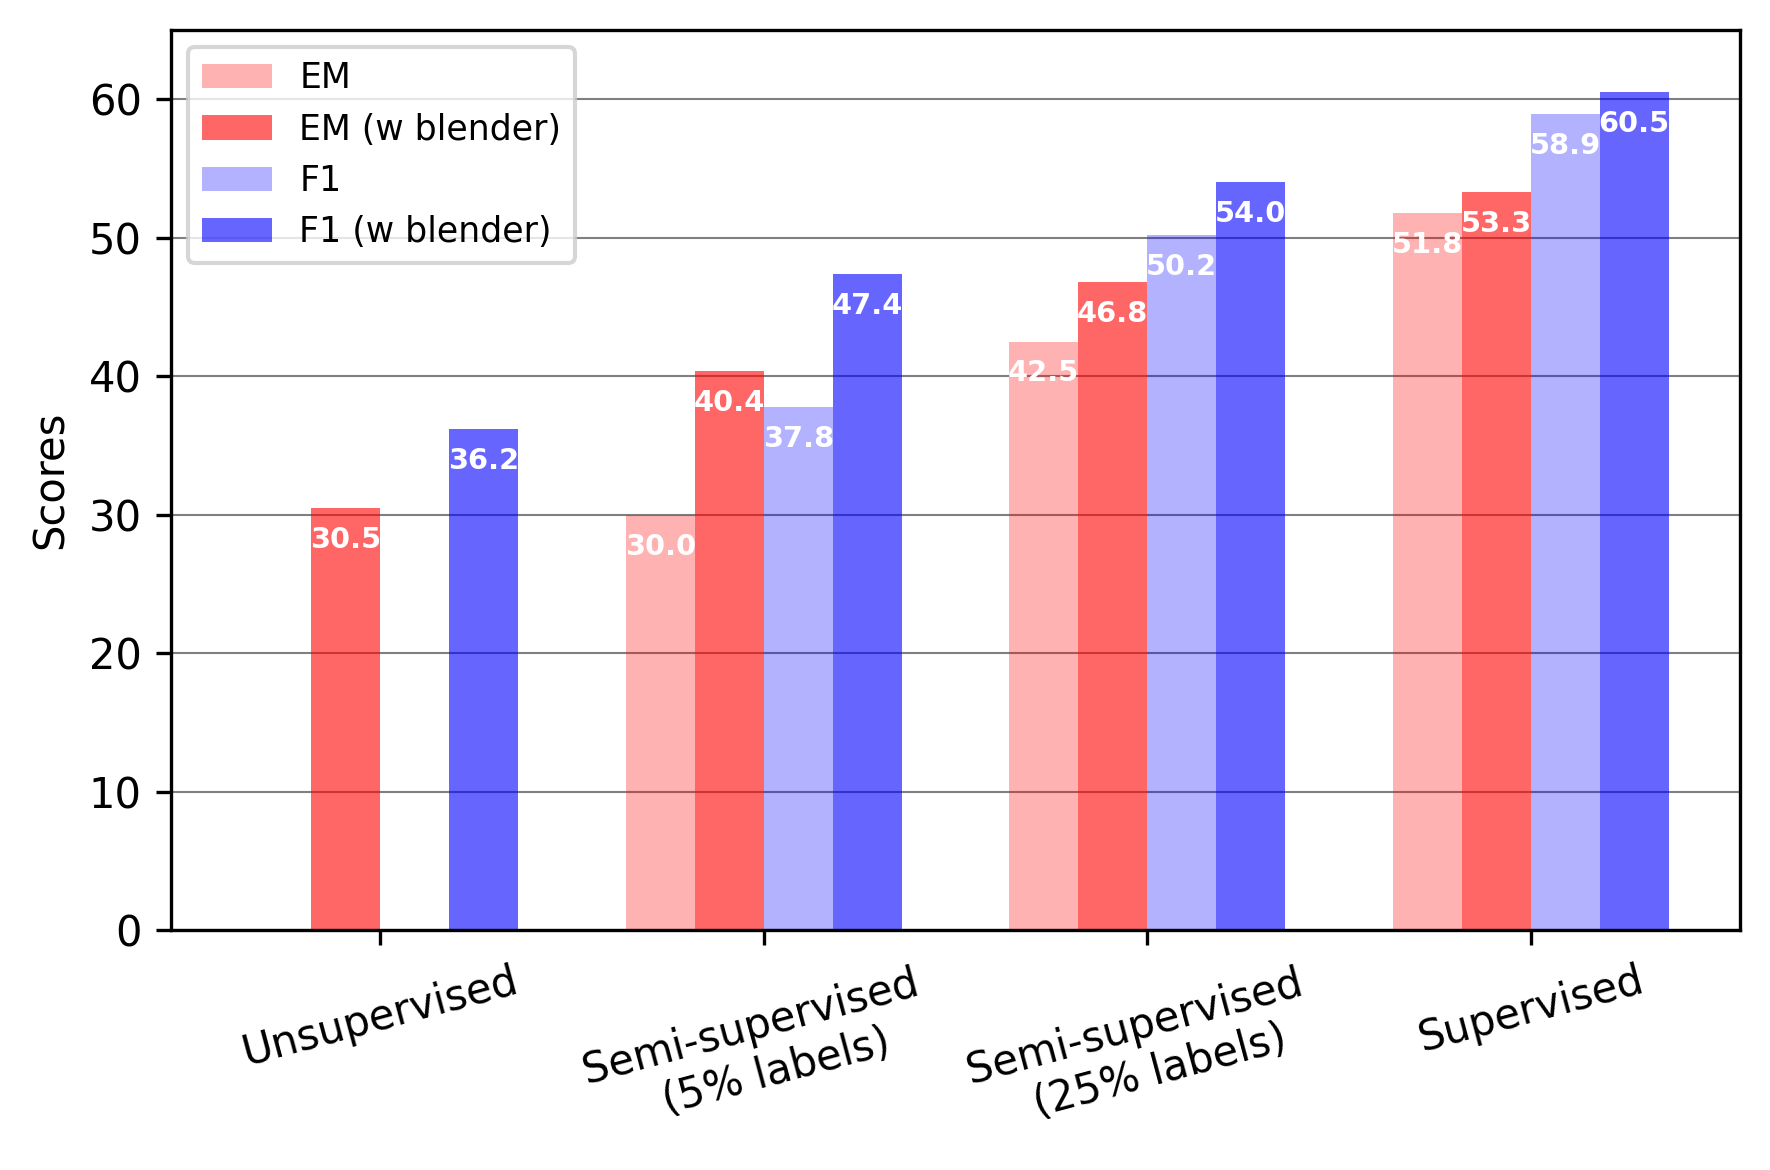

In [56]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

labels = ['Unsupervised', 'Semi-supervised \n (5% labels)', 'Semi-supervised \n (25% labels)', 'Supervised']
EM_wo_data_aug = [0.0, 30.0, 42.5, 51.8]
EM_w_data_aug = [30.5, 40.4, 46.8, 53.3]
F1_wo_data_aug = [0.0, 37.8, 50.2, 58.9]
F1_w_data_aug = [36.2, 47.4, 54.0, 60.5]

x = np.arange(len(labels))  # the label locations
width = 0.18  # the width of the bars

fig, ax = plt.subplots()
# plt.rc('grid', linestyle="-", color='black')
# plt.grid(axis = 'y', linewidth = 1)
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linewidth= 0.5)

rects1 = ax.bar(x - 3*width/2, EM_wo_data_aug, width, color = (1.0,0.0,0.0,0.3), label='EM')
rects2 = ax.bar(x - width/2, EM_w_data_aug, width, color = (1.0,0.0,0.0,0.6), label='EM (w blender)')
rects3 = ax.bar(x + width/2, F1_wo_data_aug, width, color = (0.0,0.0,1.0,0.3), label='F1')
rects4 = ax.bar(x + 3*width/2, F1_w_data_aug, width, color = (0.0,0.0,1.0,0.6), label='F1 (w blender)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_xticks(x)
ax.set_ylim(0, 65)
ax.set_xticklabels(labels)
plt.xticks(x, labels, rotation=15)
ax.legend(fontsize='small')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, -11),  # 3 points vertical offset
                    textcoords="offset points",
                    color = (1.0,1.0,1.0,1.0),
                    fontsize = 'x-small',
                    fontweight = 'bold',
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()

fig.show()

## Plot Few-shot Learning Figure

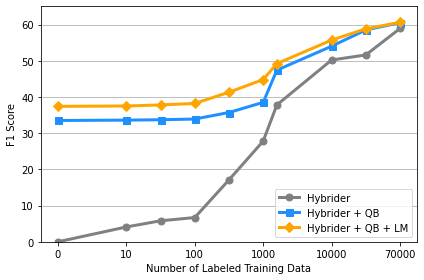

In [1]:
# libraries
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, FixedLocator
import numpy as np
import pandas as pd

### data
X = [1, 2, 2.5, 3, 3.5, 4, 4.2, 5, 5.5, 6]
Hybrider = [0, 4.1, 5.8, 6.7, 17.1, 27.8, 37.8, 50.2, 51.6, 58.9]
Hybrider_QB = [33.5, 33.6, 33.7, 33.9, 35.7, 38.5, 47.4, 54, 58.5, 60.5]
# Hybrider_QB_LM = [36.2, 36.3, 36.6, 37.0, 40.1, 43.6, 48.9, 55.4, 58.8, 60.6]
Hybrider_QB_LM = [37.4, 37.5, 37.8, 38.2, 41.3, 44.8, 49.2, 55.7, 58.8, 60.6]

### figure
fig, ax = plt.subplots()
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linewidth= 0.5)

ax.set_xlabel('Number of Labeled Training Data')
ax.set_ylabel('F1 Score')
ax.set_xticks(X)
ax.set_ylim(0, 65)
xmajorLocator = FixedLocator([1, 2, 3, 4, 5, 6])
ax.xaxis.set_major_locator(xmajorLocator)

labels = ['0', '10', '100', '1000', '10000', '70000']
ax.set_xticklabels(labels)

# multiple line plot
plt.plot(X, Hybrider, label='Hybrider', marker='o', markerfacecolor='grey', markersize=7, color='grey', linewidth=3)
plt.plot(X, Hybrider_QB, label='Hybrider + QB', marker='s', markerfacecolor='dodgerblue', markersize=7, color='dodgerblue', linewidth=3)
plt.plot(X, Hybrider_QB_LM, label='Hybrider + QB + LM', marker='D', markerfacecolor='orange', markersize=7, color='orange', linewidth=3)

plt.legend(fontsize='medium', loc = 'lower right')

fig.tight_layout()

fig.show()


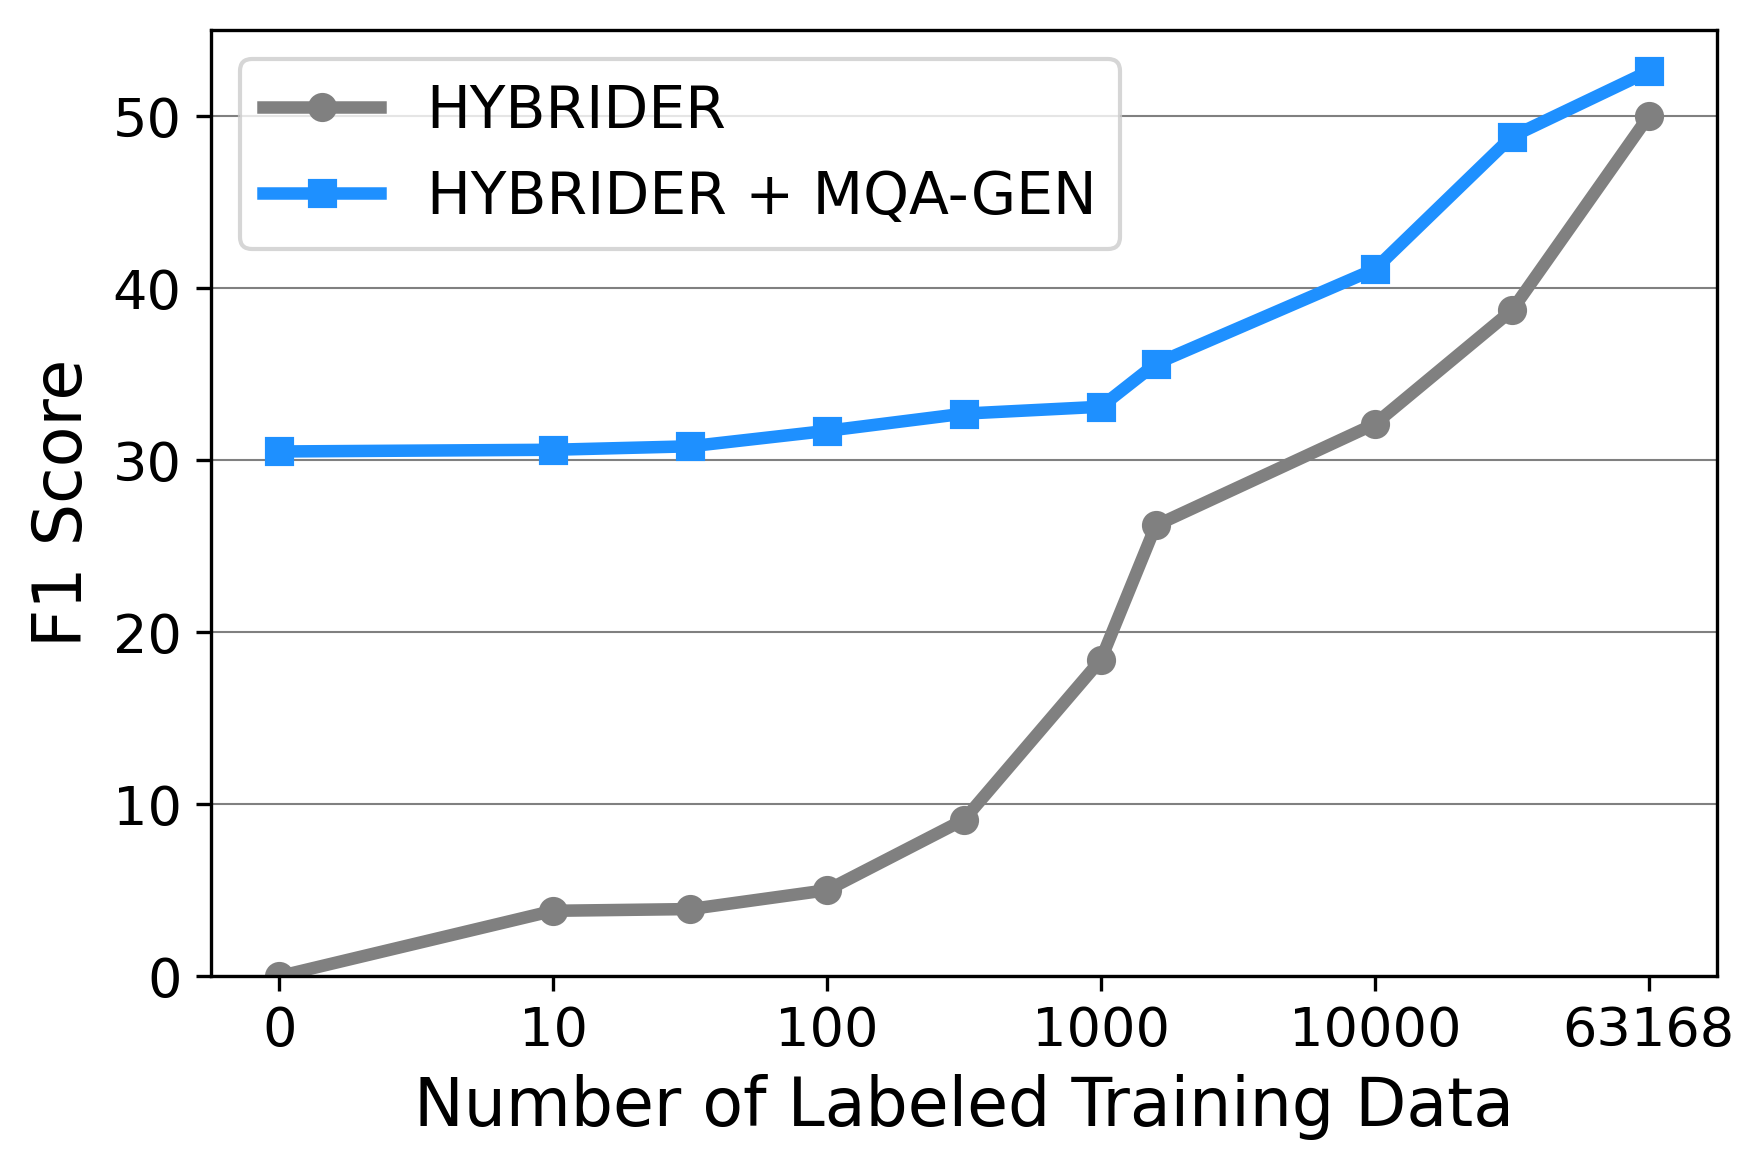

In [21]:
# libraries
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, FixedLocator
import numpy as np
import pandas as pd

### data
X = [1, 2, 2.5, 3, 3.5, 4, 4.2, 5, 5.5, 6]
Hybrider = [0, 3.8, 3.9, 5.0, 9.1, 18.4, 26.2, 32.1, 38.7, 50.0]
Hybrider_QB = [28.2, 28.2, 28.3, 28.5, 29.0, 30.3, 32.4, 39.9, 47.8, 51.7]
# Hybrider_QB_LM = [36.2, 36.3, 36.6, 37.0, 40.1, 43.6, 48.9, 55.4, 58.8, 60.6]
Hybrider_QB_LM = [30.5, 30.6, 30.8, 31.7, 32.7, 33.1, 35.6, 41.1, 48.8, 52.6]

### figure
fig, ax = plt.subplots()
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linewidth= 0.5)

ax.set_xlabel('Number of Labeled Training Data', fontsize=16)
ax.set_ylabel('F1 Score', fontsize=16)

plt.tick_params(labelsize=13)
ax.set_xticks(X)
ax.set_ylim(0, 55)
xmajorLocator = FixedLocator([1, 2, 3, 4, 5, 6])
ax.xaxis.set_major_locator(xmajorLocator)

labels = ['0', '10', '100', '1000', '10000', '63168']
ax.set_xticklabels(labels)

# multiple line plot
plt.plot(X, Hybrider, label='HYBRIDER', marker='o', markerfacecolor='grey', markersize=6, color='grey', linewidth=3)
plt.plot(X, Hybrider_QB_LM, label='HYBRIDER + MQA-GEN', marker='s', markerfacecolor='dodgerblue', markersize=6, color='dodgerblue', linewidth=3)
# plt.plot(X, Hybrider_QB_LM, label='Hybrider + MQA-GEN + LM', marker='D', markerfacecolor='orange', markersize=6, color='orange', linewidth=3)

# dodgerblue

plt.legend(fontsize=14, loc = 'upper left')

fig.tight_layout()

fig.show()

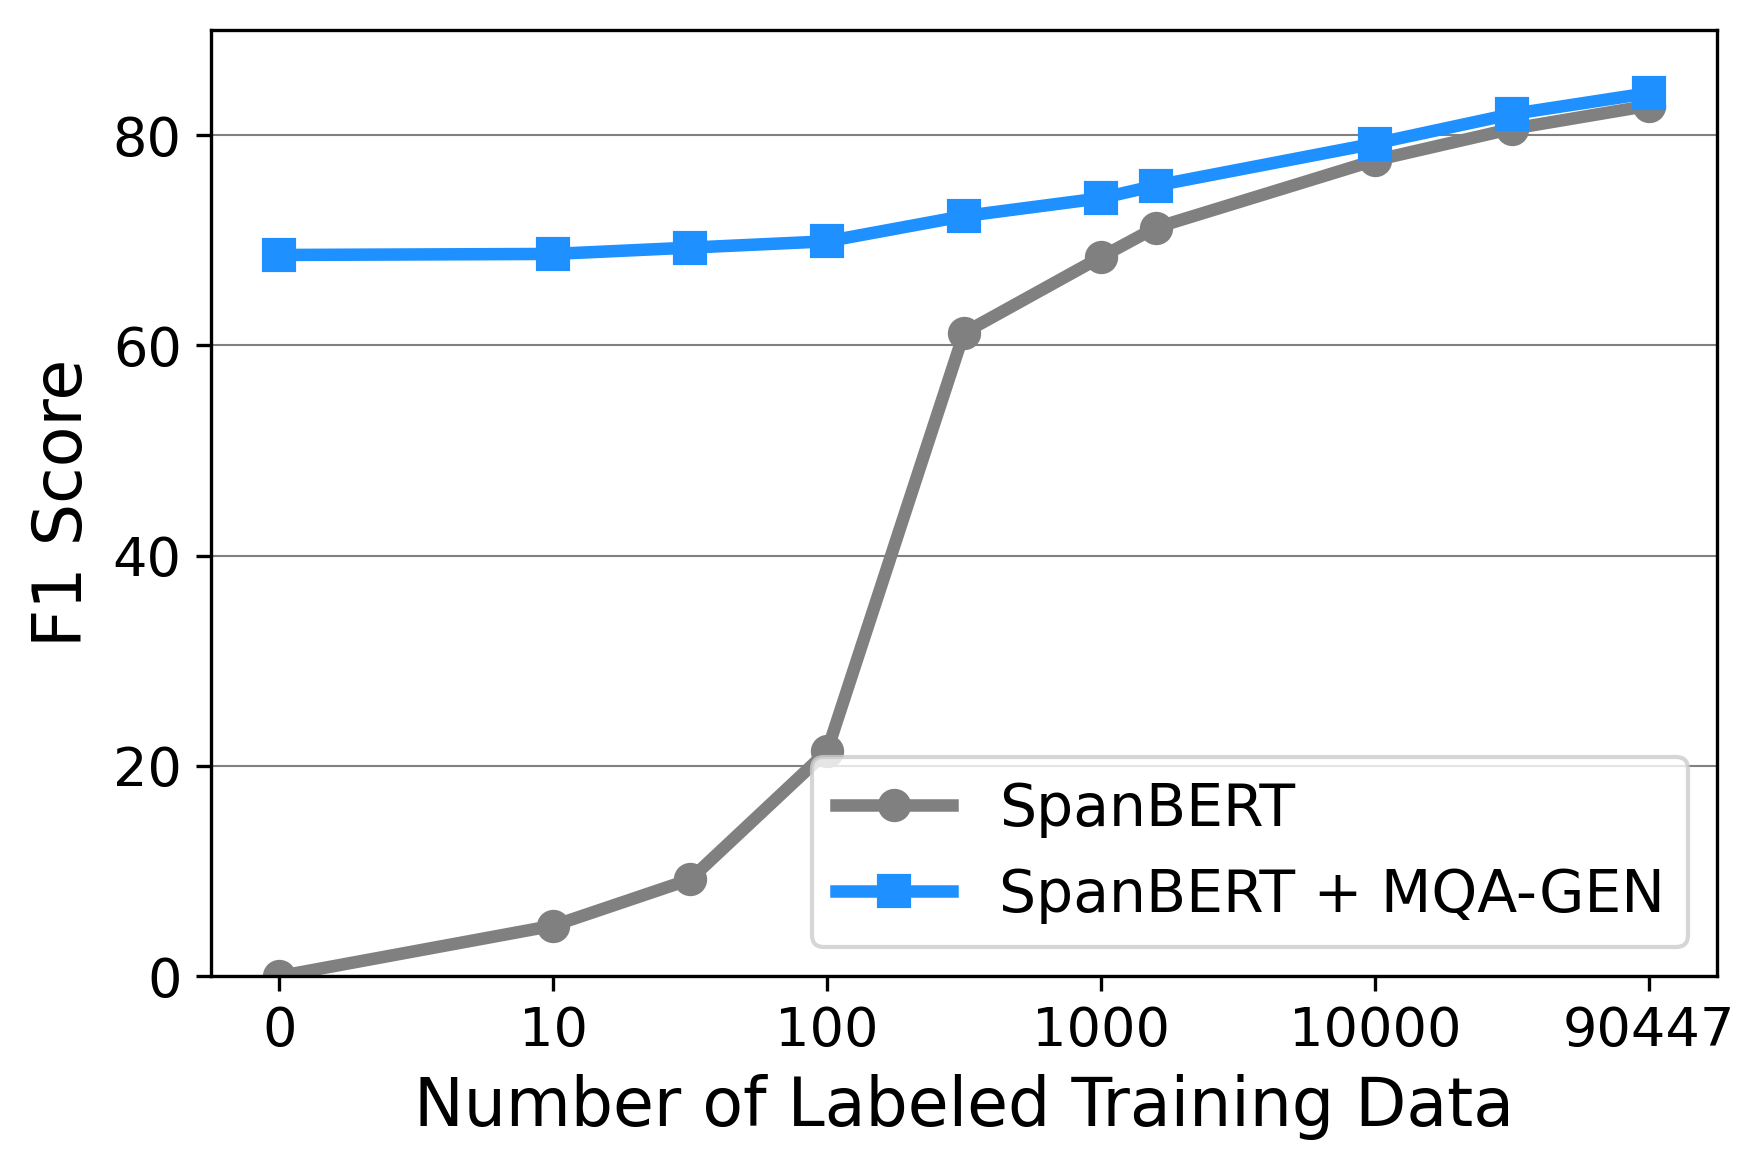

In [7]:
# libraries
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, FixedLocator
import numpy as np
import pandas as pd

### data
X = [1, 2, 2.5, 3, 3.5, 4, 4.2, 5, 5.5, 6]

# old data
#SpanBERT = [0, 7.8, 21.6, 33.9, 50.7, 64.3, 67.7, 69.7, 73.9, 74.4]
#SpanBERT_QB_LM = [62.8, 63.7, 64.6, 65.7, 68.3, 68.4, 69.3, 71.0, 74.8, 75.6]

SpanBERT = [0, 4.8, 9.2, 21.4, 61.2, 68.4, 71.2, 77.6, 80.6, 82.8]
SpanBERT_QB_LM = [68.6, 68.7, 69.3, 69.9, 72.3, 74.0, 75.2, 79.2, 82.0, 84.0]

### figure
fig, ax = plt.subplots()
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linewidth= 0.5)

ax.set_xlabel('Number of Labeled Training Data', fontsize=16)
ax.set_ylabel('F1 Score', fontsize=16)

plt.tick_params(labelsize=13)
ax.set_xticks(X)
ax.set_ylim(0, 90)
xmajorLocator = FixedLocator([1, 2, 3, 4, 5, 6])
ax.xaxis.set_major_locator(xmajorLocator)

labels = ['0', '10', '100', '1000', '10000', '90447']
ax.set_xticklabels(labels)

# multiple line plot
plt.plot(X, SpanBERT, label='SpanBERT', marker='o', markerfacecolor='grey', markersize=7, color='grey', linewidth=3)
plt.plot(X, SpanBERT_QB_LM, label='SpanBERT + MQA-GEN', marker='s', markerfacecolor='dodgerblue', markersize=7, color='dodgerblue', linewidth=3)

# dodgerblue

plt.legend(fontsize=14, loc = 'lower right')

fig.tight_layout()

fig.show()

## HotpotQA Comparison Question Testing

In [1]:
import json

def load_hotpotQA(data_path, file_name):
    with open(data_path + file_name, 'r') as f:
        dataset = json.load(f)
    return dataset

def title_match(evidences, title):
    for eve in evidences:
        if title.strip().find(eve.strip()) >=0:
            return True
    return False 

'''
1. select only bridge-type questions
2. select only evidence passages
output: train/dev.src.txt ; train/dev.qa.txt
'''
def build_dataset(data_path, file_name, data_split):
    dataset = load_hotpotQA(data_path, file_name)
    eve_passages = []
    QAs = []
    for sample in dataset:
        if sample['type'] == 'comparison':
            # add QA
            qa_pairs = {'passage_id': sample['_id'], 
                        'ques_ans': [
                            {'question': sample['question'], 'answer': sample['answer']}
                        ]}
            # add passage
            evidences = set([ele[0] for ele in sample['supporting_facts']])
            evidence_passages = []
            for passage in sample['context']:
                title, sentences = passage[0], passage[1]
                if title_match(evidences, title) == True:
                    article = ' '.join([sent.strip() for sent in sentences])
                    evidence_passages.append(article)
            
            if len(evidence_passages) >= 2:
                eve_passages.append({'passage_id': sample['_id'], 'context': evidence_passages})
                QAs.append(qa_pairs)
    print('Number of samples in {}: {}'.format(data_split, len(eve_passages)))
    return QAs, eve_passages

In [2]:
data_path = '/mnt/edward/data/liangming/Projects/SpanBERT/data/raw/'
train_file = 'hotpot_train_v1.1.json'
dev_file = 'hotpot_dev_distractor_v1.json'

QAs, eve_passages = build_dataset(data_path, dev_file, 'dev')

Number of samples in dev: 1487


### Observe Comparison Qs

In [3]:
QAs[0]

{'passage_id': '5a8b57f25542995d1e6f1371',
 'ques_ans': [{'question': 'Were Scott Derrickson and Ed Wood of the same nationality?',
   'answer': 'yes'}]}

In [4]:
eve_passages[0]

{'passage_id': '5a8b57f25542995d1e6f1371',
 'context': ["Ed Wood is a 1994 American biographical period comedy-drama film directed and produced by Tim Burton, and starring Johnny Depp as cult filmmaker Ed Wood. The film concerns the period in Wood's life when he made his best-known films as well as his relationship with actor Bela Lugosi, played by Martin Landau. Sarah Jessica Parker, Patricia Arquette, Jeffrey Jones, Lisa Marie, and Bill Murray are among the supporting cast.",
  'Scott Derrickson (born July 16, 1966) is an American director, screenwriter and producer. He lives in Los Angeles, California. He is best known for directing horror films such as "Sinister", "The Exorcism of Emily Rose", and "Deliver Us From Evil", as well as the 2016 Marvel Cinematic Universe installment, "Doctor Strange."',
  'Edward Davis Wood Jr. (October 10, 1924 – December 10, 1978) was an American filmmaker, actor, writer, producer, and director.']}

In [5]:
for qa_pair in QAs[:30]:
    for qa in qa_pair['ques_ans']:
        print(qa['question'] + '\t' + qa['answer'])

Were Scott Derrickson and Ed Wood of the same nationality?	yes
Are the Laleli Mosque and Esma Sultan Mansion located in the same neighborhood?	no
Are Local H and For Against both from the United States?	yes
Are Random House Tower and 888 7th Avenue both used for real estate?	no
Are Giuseppe Verdi and Ambroise Thomas both Opera composers ?	yes
Which writer was from England, Henry Roth or Robert Erskine Childers?	Robert Erskine Childers DSC
Which performance act has a higher instrument to person ratio, Badly Drawn Boy or Wolf Alice? 	Badly Drawn Boy
Are both Dictyosperma, and Huernia described as a genus?	yes
Hayden is a singer-songwriter from Canada, but where does Buck-Tick hail from?	Fujioka, Gunma
Are Freakonomics and In the Realm of the Hackers both American documentaries?	no
Which band, Letters to Cleo or Screaming Trees, had more members?	Letters to Cleo
Are both Elko Regional Airport and Gerald R. Ford International Airport located in Michigan?	no
Which dog's ancestors include Go

### QG Test

In [6]:
from QuestionRealization import T5_QG
import stanza

# QG NLP object
print('Loading QG module >>>>>>>>')
qg_nlp = T5_QG.pipeline("question-generation", model='valhalla/t5-base-qg-hl', qg_format="highlight", gpu_index = 4)
print('QG module loaded.')

Loading QG module >>>>>>>>
QG module loaded.


In [7]:
passage = eve_passages[0]['context'][2]

qa_pair = qg_nlp.qg_with_answer_text(passage, 'American')
print(qa_pair)

[{'answer': 'American', 'question': 'What nationality was Edward Davis Wood Jr.?'}]


In [8]:
passage = eve_passages[0]['context'][1]

qa_pair = qg_nlp.qg_with_answer_text(passage, 'Los Angeles')
print(qa_pair)

[{'answer': 'Los Angeles', 'question': 'Where does Scott Derrickson live?'}]


## Generating Comparison Questions

In [9]:
import stanza
# Stanza NLP object
stanza_nlp = stanza.Pipeline('en')

2020-10-04 22:55:41 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | ewt       |
| pos       | ewt       |
| lemma     | ewt       |
| depparse  | ewt       |
| ner       | ontonotes |

2020-10-04 22:55:41 INFO: Use device: gpu
2020-10-04 22:55:41 INFO: Loading: tokenize
2020-10-04 22:55:46 INFO: Loading: pos
2020-10-04 22:55:47 INFO: Loading: lemma
2020-10-04 22:55:47 INFO: Loading: depparse
2020-10-04 22:55:49 INFO: Loading: ner
2020-10-04 22:55:49 INFO: Done loading processors!


### Step 1: Locate Comparative Entities

In [32]:
'''
Types to consider: 
NORP: Nationalities or religious or political groups.
ORG: Companies, agencies, institutions, etc.
GPE: Countries, cities, states.
LOC: Non-GPE locations, mountain ranges, bodies of water.
DATE: Absolute or relative dates or periods.
'''
def locate_comparative_entity(evidences):
    valid_NER_types = ['NORP', 'ORG', 'GPE', 'LOC', 'DATE']
    evidences_with_ents = []
    for source in evidences:
        source_doc = stanza_nlp(source)
        valid_entities = []
        for ent in source_doc.ents:
            if ent.type in valid_NER_types:
                valid_entities.append([ent.text, ent.type])
        
        if len(valid_entities) > 0:
            evidences_with_ents.append({'text': source, 'ents': valid_entities})
    return evidences_with_ents

In [34]:
evidences_with_ents = locate_comparative_entity(eve_passages[0]['context'])
print(evidences_with_ents)

[{'text': "Ed Wood is a 1994 American biographical period comedy-drama film directed and produced by Tim Burton, and starring Johnny Depp as cult filmmaker Ed Wood. The film concerns the period in Wood's life when he made his best-known films as well as his relationship with actor Bela Lugosi, played by Martin Landau. Sarah Jessica Parker, Patricia Arquette, Jeffrey Jones, Lisa Marie, and Bill Murray are among the supporting cast.", 'ents': [['1994', 'DATE'], ['American', 'NORP']]}, {'text': 'Scott Derrickson (born July 16, 1966) is an American director, screenwriter and producer. He lives in Los Angeles, California. He is best known for directing horror films such as "Sinister", "The Exorcism of Emily Rose", and "Deliver Us From Evil", as well as the 2016 Marvel Cinematic Universe installment, "Doctor Strange."', 'ents': [['July 16, 1966', 'DATE'], ['American', 'NORP'], ['Los Angeles', 'GPE'], ['California', 'GPE'], ['2016', 'DATE']]}, {'text': 'Edward Davis Wood Jr. (October 10, 1924

### Step 2: QG for comparative entities

In [35]:
def QG_for_comparative_entities(evidences_with_ents):
    evidences_with_ques = []
    for evidence in evidences_with_ents:
        passage = evidence['text']
        questions = []
        for ent in evidence['ents']:
            qa_pair = qg_nlp.qg_with_answer_text(passage, ent[0])
            for ques in qa_pair:
                questions.append({'question': ques['question'], 'answer': ques['answer'], 'type': ent[1]})
        
        if len(questions) > 0:
            evidences_with_ques.append({'text': passage, 'questions': questions})
    return evidences_with_ques

In [36]:
evidences_with_ques = QG_for_comparative_entities(evidences_with_ents)
print(evidences_with_ques)

[{'text': "Ed Wood is a 1994 American biographical period comedy-drama film directed and produced by Tim Burton, and starring Johnny Depp as cult filmmaker Ed Wood. The film concerns the period in Wood's life when he made his best-known films as well as his relationship with actor Bela Lugosi, played by Martin Landau. Sarah Jessica Parker, Patricia Arquette, Jeffrey Jones, Lisa Marie, and Bill Murray are among the supporting cast.", 'questions': [{'question': 'When was Ed Wood released?', 'answer': '1994', 'type': 'DATE'}, {'question': 'What nationality is Ed Wood?', 'answer': 'American', 'type': 'NORP'}]}, {'text': 'Scott Derrickson (born July 16, 1966) is an American director, screenwriter and producer. He lives in Los Angeles, California. He is best known for directing horror films such as "Sinister", "The Exorcism of Emily Rose", and "Deliver Us From Evil", as well as the 2016 Marvel Cinematic Universe installment, "Doctor Strange."', 'questions': [{'question': 'When was Scott Derr

### Step 3: Rule-based Merging

- (Type == 'DATE') and (Ques contains 'born') and (Ques contains PERSON ent)
    - Who is born first, ENT1 or ENT2?

In [26]:
import dateparser

def get_person_entity(ents):
    for ent in ents:
        if ent.type == 'PERSON':
            return ent.text
    return None

def compose_brithdate_question(ques1, ques2):
    if ques1['question'].find('born') < 0 or ques2['question'].find('born') < 0:
        return None
    
    ques1_doc = stanza_nlp(ques1['question'])
    ques2_doc = stanza_nlp(ques2['question'])
    if len(ques1_doc.ents) == 0 or len(ques2_doc.ents) == 0:
        return None
    
    ent1 = get_person_entity(ques1_doc.ents)
    ent2 = get_person_entity(ques2_doc.ents)
    if ent1 is None or ent2 is None:
        return None
    
    multiQ = f'Who was born first, {ent1} or {ent2}?'
    date1 = dateparser.parse(ques1['answer'])
    date2 = dateparser.parse(ques2['answer'])
    if date1 is None or date2 is None:
        return None
    answer = ent1 if date1 < date2 else ent2
    return [{'question': multiQ, 'answer': answer}]

- (Type == GPE or LOC) and (Ques contains 'live') and (Ques contains PERSON ent)
    - Are ENT1 and ENT2 living in the same place?
    - Which person lives in ANS1, ENT1 or ENT2?

In [27]:
def compose_liveplace_question(ques1, ques2):
    if ques1['question'].find('live') < 0 or ques2['question'].find('live') < 0:
        return None
    
    ques1_doc = stanza_nlp(ques1['question'])
    ques2_doc = stanza_nlp(ques2['question'])
    if len(ques1_doc.ents) == 0 or len(ques2_doc.ents) == 0:
        return None
    
    ent1 = get_person_entity(ques1_doc.ents)
    ent2 = get_person_entity(ques2_doc.ents)
    if ent1 is None or ent2 is None:
        return None
    
    results = []
    multiQ1 = f'Are {ent1} and {ent2} living in the same place?'
    answer1 = 'yes' if ques1['answer'].lower() == ques2['answer'].lower() else 'no'
    results.append({'question': multiQ1, 'answer': answer1})
    
    multiQ2 = f'''Which person lives in {ques1['answer']}, {ent1} or {ent2}?'''
    answer2 = ent1
    results.append({'question': multiQ2, 'answer': answer2})
    
    multiQ3 = f'''Which person lives in {ques2['answer']}, {ent1} or {ent2}?'''
    answer4 = ent2
    results.append({'question': multiQ3, 'answer': answer3})
    
    return results

- (Type == NORP) and (Ques contains 'nationality') and (Ques contains PERSON ent)
    - Are ENT1 and ENT2 of the same nationality?
    - Which person is from ANS1, ENT1 or ENT2?

In [39]:
def compose_nationality_question(ques1, ques2):
    if ques1['question'].find('nationality') < 0 or ques2['question'].find('nationality') < 0:
        return None
    
    ques1_doc = stanza_nlp(ques1['question'])
    ques2_doc = stanza_nlp(ques2['question'])
    if len(ques1_doc.ents) == 0 or len(ques2_doc.ents) == 0:
        return None
    
    ent1 = get_person_entity(ques1_doc.ents)
    ent2 = get_person_entity(ques2_doc.ents)
    if ent1 is None or ent2 is None:
        return None
    
    results = []
    multiQ1 = f'Are {ent1} and {ent2} of the same nationality?'
    answer1 = 'yes' if ques1['answer'].lower() == ques2['answer'].lower() else 'no'
    results.append({'question': multiQ1, 'answer': answer1})
    
    multiQ2 = f'''Which person is from {ques1['answer']}, {ent1} or {ent2}?'''
    answer2 = ent1
    results.append({'question': multiQ2, 'answer': answer2})
    
    multiQ3 = f'''Which person is from {ques2['answer']}, {ent1} or {ent2}?'''
    answer3 = ent2
    results.append({'question': multiQ3, 'answer': answer3})
    
    return results

- (Type == GPE or LOC) and (Ques contains 'located') and (Ques contains ent)
    - Are ENT1 and ENT2 located in the same place?
    - Which one is located in ANS1, ENT1 or ENT2?
    - Are both ENT1 and ENT2 located in ANS1?

In [40]:
def get_first_entity(ents):
    for ent in ents:
        return ent.text
    return None

def compose_location_question(ques1, ques2):
    if ques1['question'].find('located') < 0 or ques2['question'].find('located') < 0:
        return None
    
    ques1_doc = stanza_nlp(ques1['question'])
    ques2_doc = stanza_nlp(ques2['question'])
    if len(ques1_doc.ents) == 0 or len(ques2_doc.ents) == 0:
        return None
    
    ent1 = get_first_entity(ques1_doc.ents)
    ent2 = get_first_entity(ques2_doc.ents)
    if ent1 is None or ent2 is None:
        return None
    
    results = []
    multiQ1 = f'Are {ent1} and {ent2} located in the same place?'
    answer1 = 'yes' if ques1['answer'].lower() == ques2['answer'].lower() else 'no'
    results.append({'question': multiQ1, 'answer': answer1})
    
    multiQ2 = f'''Which one is located in {ques1['answer']}, {ent1} or {ent2}?'''
    answer2 = ent1
    results.append({'question': multiQ2, 'answer': answer2})
    
    multiQ3 = f'''Which one is located in {ques2['answer']}, {ent1} or {ent2}?'''
    answer3 = ent2
    results.append({'question': multiQ3, 'answer': answer3})
    
    multiQ4 = f'''Are both {ent1} and {ent2} located in {ques1['answer']}?'''
    answer4 = 'yes' if ques1['answer'].lower() == ques2['answer'].lower() else 'no'
    results.append({'question': multiQ4, 'answer': answer4})
    
    return results

In [41]:
valid_questions = []

for i in range(len(evidences_with_ques)):
    for j in range(i+1, len(evidences_with_ques)):
        eve1, eve2 = evidences_with_ques[i], evidences_with_ques[j]
        # for each question pair
        for ques1 in eve1['questions']:
            for ques2 in eve2['questions']:
                if ques1['type'] == 'DATE' and ques2['type'] == 'DATE':
                    multi_ques = compose_brithdate_question(ques1, ques2)
                    if multi_ques is not None:
                        valid_questions += multi_ques
                if ques1['type'] in ['GPE', 'LOC'] and ques2['type'] in ['GPE', 'LOC']:
                    multi_ques = compose_liveplace_question(ques1, ques2)
                    if multi_ques is not None:
                        valid_questions += multi_ques
                    multi_ques = compose_location_question(ques1, ques2)
                    if multi_ques is not None:
                        valid_questions += multi_ques
                if ques1['type'] == 'NORP' and ques2['type'] == 'NORP':
                    multi_ques = compose_nationality_question(ques1, ques2)
                    if multi_ques is not None:
                        valid_questions += multi_ques

In [42]:
valid_questions

[{'question': 'Are Ed Wood and Scott Derrickson of the same nationality?',
  'answer': 'yes'},
 {'question': 'Which person is from American, Ed Wood or Scott Derrickson?',
  'answer': 'Ed Wood'},
 {'question': 'Which person is from American, Ed Wood or Scott Derrickson?',
  'answer': 'Scott Derrickson'},
 {'question': 'Are Ed Wood and Edward Davis Wood Jr. of the same nationality?',
  'answer': 'yes'},
 {'question': 'Which person is from American, Ed Wood or Edward Davis Wood Jr.?',
  'answer': 'Ed Wood'},
 {'question': 'Which person is from American, Ed Wood or Edward Davis Wood Jr.?',
  'answer': 'Edward Davis Wood Jr.'},
 {'question': 'Who was born first, Scott Derrickson or Edward Davis Wood Jr.?',
  'answer': 'Edward Davis Wood Jr.'},
 {'question': 'Are Scott Derrickson and Edward Davis Wood Jr. of the same nationality?',
  'answer': 'yes'},
 {'question': 'Which person is from American, Scott Derrickson or Edward Davis Wood Jr.?',
  'answer': 'Scott Derrickson'},
 {'question': 'Wh

## Question Type Analysis

In [1]:
import json

def load_dataset(file_path):
    with open(file_path) as f:
        dataset = json.load(f)
    return dataset

human_path = '/mnt/edward/data/liangming/Projects/New_HybridQA/Data/released_data/train.json'
synthesized_path = '/mnt/edward/data/liangming/Projects/New_HybridQA/HybridQA/synthesized_data/train_top100000_New.json'

human_dataset = load_dataset(human_path)
synthesized_dataset = load_dataset(synthesized_path)

In [7]:
from collections import defaultdict

# question type
QUESTION_TYPES = [
    "Who", "Where", "When", "Why", "Which", "What", "How",
    "Boolean", "Other"]
INFO_QUESTION_TYPES = [
    "Who", "Where", "When", "Why", "Which", "What", "How"]
BOOL_QUESTION_TYPES = [
    "Am", "Is", "Was", "Were", "Are",
    "Does", "Do", "Did",
    "Have", "Had", "Has",
    "Could", "Can",
    "Shall", "Should",
    "Will", "Would",
    "May", "Might"]
Q_TYPE2ID_DICT = {
    "What": 0, "Who": 1, "How": 2,
    "Where": 3, "When": 4, "Why": 5,
    "Which": 6, "Boolean": 7, "Other": 8}

def get_question_type(question):
    """
    Given a string question, return its type name and type id.
    :param question: question string.
    :return: (question_type_str, question_type_id)
    """
    words = question.split()
    for word in words:
        for i in range(len(INFO_QUESTION_TYPES)):
            if INFO_QUESTION_TYPES[i].upper() in word.upper():
                return (INFO_QUESTION_TYPES[i],
                        Q_TYPE2ID_DICT[INFO_QUESTION_TYPES[i]])
    for i in range(len(BOOL_QUESTION_TYPES)):
        if BOOL_QUESTION_TYPES[i].upper() == words[0].upper():
            return ("Boolean", Q_TYPE2ID_DICT["Boolean"])
    return ("Other", Q_TYPE2ID_DICT["Other"])


def analysis_question_types(dataset):
    raw_questions = [sample['question'] for sample in dataset]
    total = len(raw_questions)
    count_dict = defaultdict(int)
    for question in raw_questions:
        q_type = get_question_type(question)[0]
        count_dict[q_type] += 1
        
    for key in count_dict:
        count_dict[key] = count_dict[key] / total
    return count_dict

In [8]:
analysis_question_types(synthesized_dataset)

defaultdict(int,
            {'What': 0.48421,
             'When': 0.14676,
             'How': 0.09202,
             'Who': 0.1252,
             'Where': 0.13356,
             'Which': 0.0103,
             'Why': 0.00025,
             'Other': 0.00757,
             'Boolean': 0.00013})

In [9]:
analysis_question_types(human_dataset)

defaultdict(int,
            {'Who': 0.10583580613254204,
             'What': 0.5616604447847867,
             'Which': 0.15096838007721514,
             'How': 0.11529625729874605,
             'When': 0.040075300724290865,
             'Where': 0.02187230783957117,
             'Other': 0.003366197632494177,
             'Boolean': 0.0005424204715867394,
             'Why': 0.0003828850387671102})

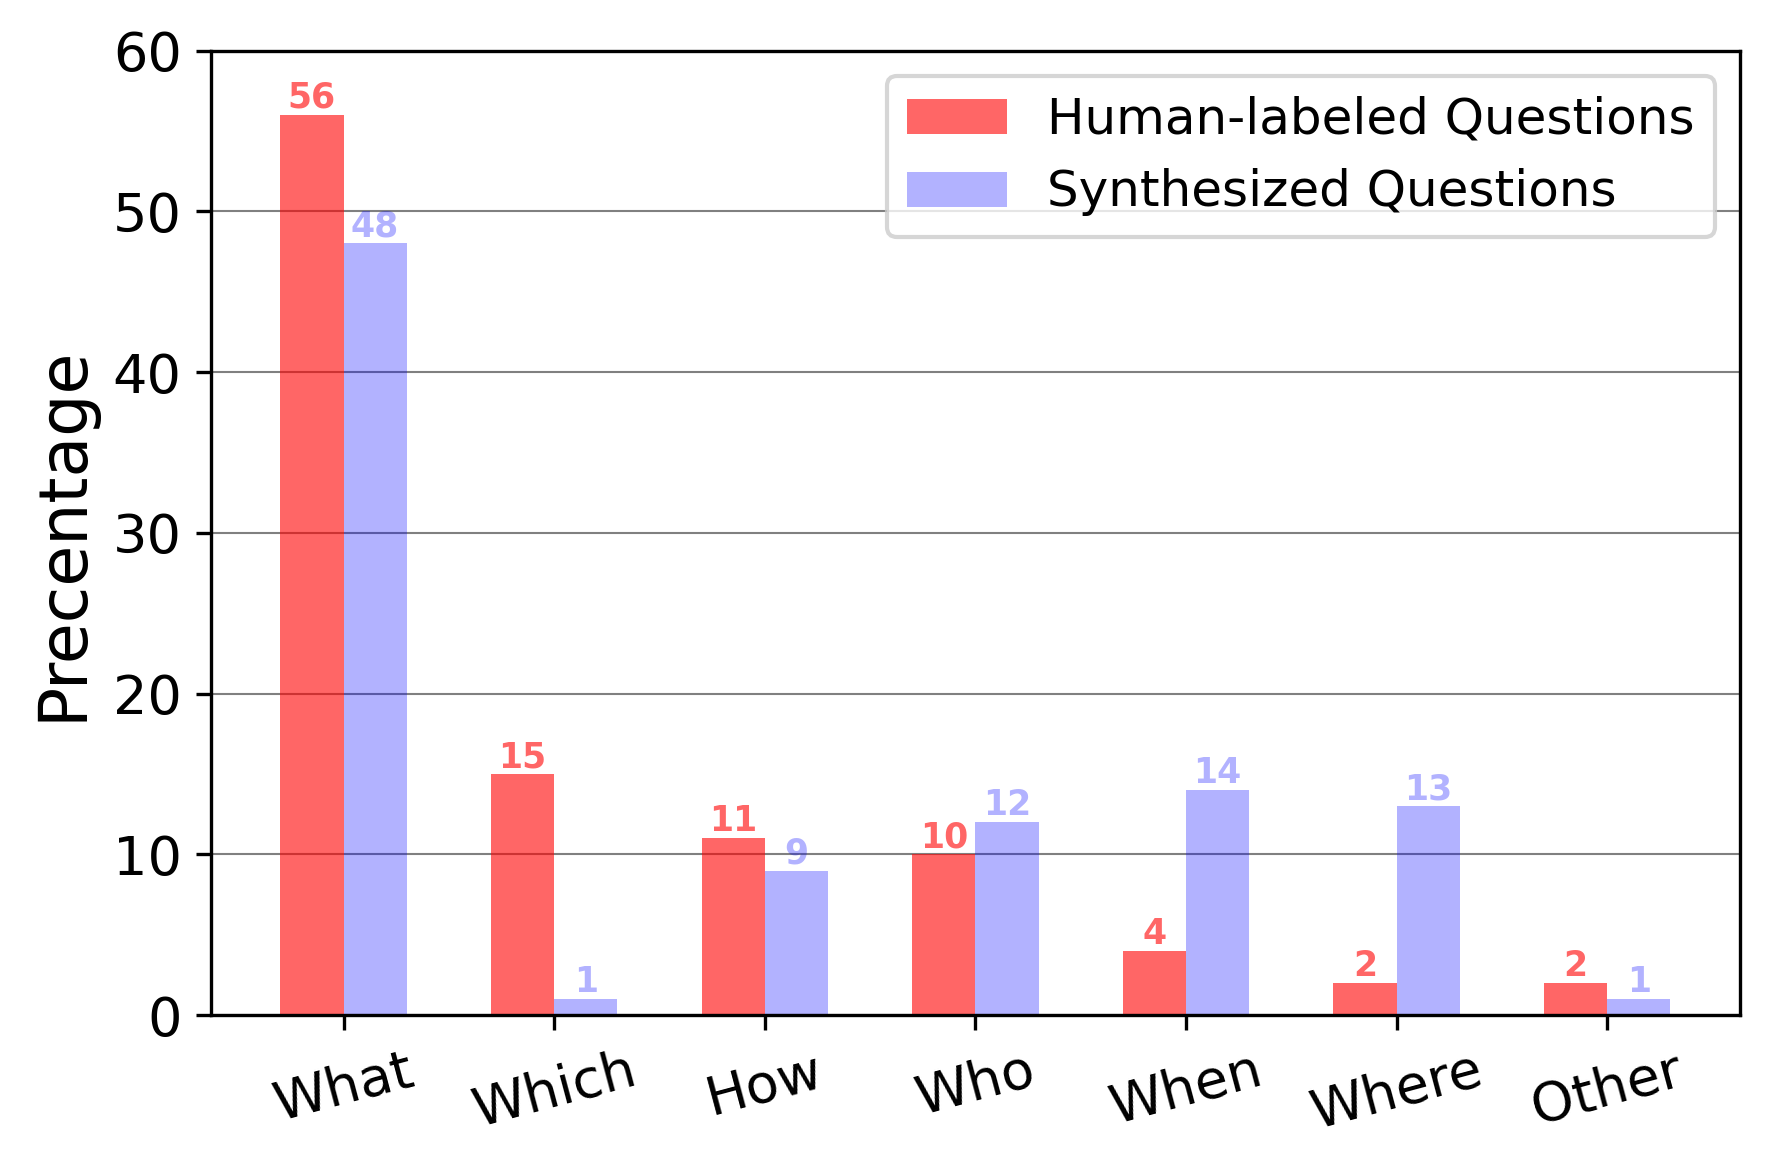

In [42]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

labels = ['What', 'Which', 'How', 'Who', 'When', 'Where', 'Other']
human_data = [56, 15, 11, 10, 4, 2, 2]
synthesized_data = [48, 1, 9, 12, 14, 13, 1]

x = np.arange(len(labels))  # the label locations
width = 0.30  # the width of the bars

fig, ax = plt.subplots()
# plt.rc('grid', linestyle="-", color='black')
# plt.grid(axis = 'y', linewidth = 1)
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linewidth= 0.5)


rect_human = ax.bar(x - width/2, human_data, width, color = (1.0,0.0,0.0,0.6), label='Human-labeled Questions')
rect_synthesized = ax.bar(x + width/2, synthesized_data, width, color = (0.0,0.0,1.0,0.3), label='Synthesized Questions')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Precentage', fontsize = 16)
plt.tick_params(labelsize=13)
ax.set_xticks(x)
ax.set_ylim(0, 60)
ax.set_xticklabels(labels)
plt.xticks(x, labels, rotation=15)
# ax.legend(fontsize=14)
plt.legend(fontsize=12, loc = 'upper right')

def autolabel(rects, color_to_use):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 0),  # 3 points vertical offset
                    textcoords="offset points",
                    color = color_to_use,
                    fontsize = 'small',
                    fontweight = 'bold',
                    ha='center', va='bottom')

autolabel(rect_human, (1.0,0.0,0.0,0.6))
autolabel(rect_synthesized, (0.0,0.0,1.0,0.3))

fig.tight_layout()

fig.show()